In [1]:
import re
import regex as reg
import pandas as pd
import os
import sys
import json
import numpy as np
%matplotlib inline
USER_ENV = '../data/' 
rootdir = USER_ENV + 'papers/'

In this notebook I will describe the extraction of information relating to the affiliation of the paper authors.
To this means, I used the header section of each paper:

In [2]:
#reads txt file of each paper and stores it in contents
contents = []
i = 0
source = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if 'txt' in file:
            source.append(file[:-4])
            i += 1
            path = os.path.join(subdir, file)
            with open(path) as file:
                try:
                    text = file.read()
                    contents.append(text)
                except:
                    #Will fails for some files in python 3 
                    name, message, content = sys.exc_info()
                    print(message)

In [3]:
paper_text = pd.DataFrame([contents, source]).T.rename(columns={0:'text', 1:'file'})

In [4]:
paper_text.head()

,text,file
0,Learning Scientific Practices Through Particip...,import2018_371
1,Visualizing Complex Classrooms Through Real Ti...,import2018_417
2,Opening the Door to Algebra: The Role of Fract...,import2018_403
3,Measuring Maker Mindset: Establishing Content ...,import2018_365
4,Fostering University Freshmen’s Mathematical A...,import2016full_78


## Finding affiliation (University) using email:

### Domain mapping:

Importing the mapping from domain to university (and country!)

In [5]:
schools = open(USER_ENV+'world_universities_and_domains.json').read()
parsed_json = json.loads(schools)

Number of schools in json

In [6]:
len(parsed_json)

9691

#### Rational for using email vs extracting institution from text:
- easier to parse from text
- unique / more robust to spelling changes

what is the maximal number of domains per school?

In [7]:
print('Maximal number of domains per school: ', max([len(j['domains']) for j in parsed_json]))

Maximal number of domains per school:  3


In [8]:
#creating the mapping from domain to university
mapping = {}
#creating mapping from domain to country
country_uni = {}
for j in parsed_json:
    mapping[j['domains'][0]] = j['name']
    country_uni[j['domains'][0]] = j['country']
    if len(j['domains']) > 1:
        mapping[j['domains'][1]] = j['name']
        country_uni[j['domains'][1]] = j['country']
    if len(j['domains']) > 2:
        mapping[j['domains'][2]] = j['name']
        country_uni[j['domains'][2]] = j['country']

We decided to add the following domains as they come up often and do not appear in the above dataset:

In [9]:
#adding in the most common university names not in json
mapping['nie.edu.sg'] = "National Institute of Education (NIE), Singapore"
mapping['rub.de'] = "Ruhr-University Bochum"
mapping['uni-due.de'] = "Universität Duisburg-Essen"
mapping['collide.info'] = "Universität Duisburg-Essen"
mapping['dawsoncollege.qc.ca'] = "Dawson College"
mapping['dawsoncollege.ca'] = "Dawson College"
mapping['johnabbott.qc.ca'] = "John Abbott College"
mapping['johnabbott.ca'] = "John Abbott College"
mapping['vaniercollege.qc.ca'] = 'Vanier Colleege'

The following two functions are used to get the mapping for a given email and extract the email from text:

In [10]:
def get_school_from_mail(mail, mapping):
    """Maps email to institution"""
    if mail in mapping:
        return mapping[mail], mail
    elif reg.findall('[\p{L}0-9\-]*\.[\p{L}0-9\-]*$', mail)[0] in mapping:
        double = reg.findall('[\p{L}0-9\-]*\.[\p{L}0-9\-]*$', mail)[0]
        return mapping[double], double
    else:
        triplet = reg.findall('[\p{L}0-9\-]*\.[\p{L}0-9\-]*\.[\p{L}0-9\-]*$', mail)
        if len(triplet) > 0 and triplet[0] in mapping:
            return (mapping[triplet[0]], triplet[0])
        else:
            return np.nan, mail

In [11]:
def find_emails(x):
    text, file = x.text, x.file
    abstract_pos = text.find('\nAbstract')
    
    mails_in_paper = reg.findall('[\p{L}0-9\.\-\+\_]*@[\p{L}0-9\.\-]*\.[\p{L}0-9\.\-]*(?!\S*\:\S*)', 
                                 text[:abstract_pos])
    return [(file, get_school_from_mail(m.split('@')[1].lower(), mapping), m) for m in mails_in_paper]
    

In [12]:
paper_text = paper_text.dropna()

In [13]:
emails = pd.DataFrame([ (email[0], email[1][0], email[1][1], email[2], i) 
              for paper in paper_text.apply(find_emails, axis=1).tolist() for i, email in enumerate(paper)]
            , columns=['file', 'name', 'domain', 'email', 'author_order'])

In [14]:
emails.head()

,file,name,domain,email,author_order
0,import2018_371,University of Colorado at Boulder,colorado.edu,rebecca.swanson@colorado.edu,0
1,import2018_371,University of Colorado at Boulder,colorado.edu,leighanna.hinojosa@colorado.edu,1
2,import2018_371,University of Colorado at Boulder,colorado.edu,joseph.polman@colorado.edu,2
3,import2018_417,Indiana University at Bloomington,indiana.edu,huang220@indiana.edu,0
4,import2018_417,NaN,gmail.com,agomoll90@gmail.com,1


Number of files that could be parsed:

In [15]:
print('Papers from which we parse mails : ', len(emails.file.unique()))
print('Total number of papers : ', len(paper_text.file.unique()))

Papers from which we parse mails :  864
Total number of papers :  874


Papers for which we can not find emails are papers that were not parsed propperly:

In [16]:
bad_files = set(paper_text.file.tolist())- set(emails.file.tolist())
bad_files

{'import2016full_91',
 'import2016full_92',
 'import2016full_93',
 'import2016full_94',
 'import2016full_95',
 'import2016full_96',
 'import2016full_97',
 'import2016full_98',
 'import2016short_146',
 'import2018_246'}

In [17]:
paper_text[paper_text.file == 'import2016full_91'].text

106    Author Index\nPages 1-702: Volume 1\nPages 703...
Name: text, dtype: object

In [18]:
paper_text[paper_text.file == 'import2018_246'].text.tolist()[0][:200]

'Multimodal Learning Analytics for the Qualitative Researcher\nAuthor Name, Institution, Email\nAbstract: The area of learning analytics is often viewed as a tool for supporting quantitative\nanalysis. Ba'

We are unable to get the university for 1/5 of all emails:

In [19]:
emails[emails['name'].isna()].shape[0]/emails.shape[0]

0.1689836268149521

In [20]:
emails[emails['name'].isna()].shape[0]

547

This is largely due to so many people using gmail

In [21]:
emails[emails['name'].isna()].domain.value_counts().head()

gmail.com         215
sri.com            24
concord.org        16
ets.org            11
msichicago.org     11
Name: domain, dtype: int64

### Adding the country to a person:

First we can simply use the mapping that we had defined above:

In [22]:
emails['country'] = emails.domain.map(country_uni)

In [23]:
emails.head()

,file,name,domain,email,author_order,country
0,import2018_371,University of Colorado at Boulder,colorado.edu,rebecca.swanson@colorado.edu,0,United States
1,import2018_371,University of Colorado at Boulder,colorado.edu,leighanna.hinojosa@colorado.edu,1,United States
2,import2018_371,University of Colorado at Boulder,colorado.edu,joseph.polman@colorado.edu,2,United States
3,import2018_417,Indiana University at Bloomington,indiana.edu,huang220@indiana.edu,0,United States
4,import2018_417,NaN,gmail.com,agomoll90@gmail.com,1,NaN


Number of people to whom we could not associate a country, same as number of peopel to which we could not associate a University:

In [24]:
emails.country.isna().sum()

729

However we can still add the country based on the email by identifying Country Code Top-Level Domains:

In [25]:
countries = open(USER_ENV+'/country-by-domain-tld.json').read()
parsed_countries = json.loads(countries)

In [26]:
parsed_countries[:3]

[{'country': 'Afghanistan', 'tld': '.af'},
 {'country': 'Albania', 'tld': '.al'},
 {'country': 'Algeria', 'tld': '.dz'}]

In [27]:
#reordering to define mapping
parsed_countries = { parsed['tld']: parsed['country'] for parsed in parsed_countries}

We see that some values are missing and add them to the mapping in:

In [28]:
parsed_countries['.uk']= "United Kingdom"
parsed_countries['.us']  = "United States"

The following regex will match the top level domain:

In [29]:
match_domain = '(\.[a-zA-Z0-9]*$)'

In [30]:
#example:
re.findall(match_domain,'ahaha.ad.uk')

['.uk']

In [31]:
#first extract top level domain, the use matching to assign country
emails.loc[emails.country.isna(), 'country'] = emails[emails.country.isna()].domain.map(
    lambda x: re.findall(match_domain,x)[0]).map(parsed_countries)

We can give a country to a large number of authors that way, keeping in mind that many of them are gmail adresses

In [32]:
emails.country.isna().sum()

439

In [33]:
emails[emails.country.isna()].domain.value_counts().head()

gmail.com       215
sri.com          24
collide.info     20
concord.org      16
ets.org          11
Name: domain, dtype: int64

The unmatched domains are:

In [34]:
emails[emails.country.isna()].domain.map(lambda x: re.findall(match_domain,x)[0]).value_counts()

.com             287
.org              87
.edu              22
.info             20
.net              16
.gov               2
.northwestern      1
.cg                1
.college           1
.swiss             1
.ed                1
Name: domain, dtype: int64

We can't say much about location from the remaining emails.

As still a lot of mails are remaining, we use more fancy ways to parse:

## Better email parsing using named entity detection: 

In this section we will use a complementary approach to extract more universities by using Name entitiy dectection and some clever heuristics.

First defining the data to work with:

In [35]:
#exclude bad files
pre_abstract = paper_text[~paper_text.file.isin(bad_files)].copy()

#only consider portion before abstract
pre_abstract['text'] = pre_abstract.text.map(lambda paper: paper[:paper.find('\nAbstract')])
pre_abstract['file'] = paper_text.file.copy()

In [36]:
pre_abstract.head()

,text,file
0,Learning Scientific Practices Through Particip...,import2018_371
1,Visualizing Complex Classrooms Through Real Ti...,import2018_417
2,Opening the Door to Algebra: The Role of Fract...,import2018_403
3,Measuring Maker Mindset: Establishing Content ...,import2018_365
4,Fostering University Freshmen’s Mathematical A...,import2016full_78


First, we split up the pre-abstract string in order to get the different parts, names, emails, the associated organisation.

As some universities have the following format (general location, precise location):
`University of California, Berkely`
We merge strings together if there are two subsequents segments of the string which contain a mention of a country or city. The GeoText library allows to do that. The library can not perfectly recoginize all location strings, but as it does not make calls to an external API we prefer it here. It is sufficient for this purpose:

In [37]:
from geotext import GeoText

def get_header_units(text):
    x = [reg.sub('\([\w]*\)' , '', i.strip()) for i in reg.split('\n|\,|/|;', text) if len(i.strip()) > 0]
    for i, sentence in enumerate(x):
        places = GeoText(sentence)
        if (len(places.cities) > 0 and sentence == places.cities[0]) or \
        (len(places.countries) > 0 and sentence == places.countries[0]):
            x[i-1] += ', '+sentence
            x[i] = ''
        if '@' in sentence:
            x[i] = [mail.strip() for mail in sentence.split(' ') if '@' in mail][0]
    return [i.strip() for i in x if len(i.strip()) > 0]

In [38]:
pre_abstract['split_header'] = pre_abstract.text.map(get_header_units)

to get a first idea what kind of words could help us identify universities we look at frequency counts in the string:

In [39]:
def explore_data(x):
    name = []
    for i, sentence in enumerate(x):
        if '@' in sentence:
            if not '@' in x[i-1]:
                name.append(x[i-1].split(' '))
    return [i for x in name for i in x if (len(GeoText(i).cities) == 0 and len(GeoText(i).countries) == 0) or 'University' in i]

Potential_universities = [i for x in pre_abstract.split_header.tolist() for i in explore_data(x)]

In [40]:
pd.Series(Potential_universities).value_counts().head(20)

University        1706
of                1067
and                270
State              171
The                115
at                  98
Institute           95
College             86
Technology          78
Pennsylvania        73
Indiana             69
Illinois            65
California,         57
New                 55
Stanford            48
Hong                46
Northwestern        45
Mellon              44
Duisburg-Essen      41
Kong                41
dtype: int64

from this list we gathered the following list of words marking a string as an institution of some kind:

In [41]:
Institutions = ['Universiteit', 'Università', 'Universität','University','Universidad', 'Institute',
                'Instituto', 'College', 'Col·legi', 'École','Ecole', 'Center', 'Gimnasio', 'UniDistance', 
                'Gymnasium', 'School', 'Bundeswehr', 'Foundation', 'Department', 'Universidade', 'Google', 'Technion',
               'Consortium', 'Faculty', 'CNRS', 'Ministry', 'Museum', 'Lab', 'Scuola', 'Hochschule', 'Université']

match_institutions = '|'.join(Institutions+['Eureka']).lower()

This list will be used later to refine our search and is not used uniquely to idenfity if a subsequence of a sentence is the university name or not. To find the whole list we manually went through the not so long list of potential universities
    

Instead we use spacy to tag certain entities (Named entity dectection). Spacy works reasonably well, but not well enough to just use it by itself, as it is is very error prone for the categories we use it for. It also labels asian names as organisations :(. To circumvent this we use regex to detect alternative entities and clean up string to increase the chances of a string getting labeled correctly:

In [42]:
import spacy

nlp = spacy.load('en_core_web_sm')

def person_or_org(doc):
    for ent in doc.ents:
        if  ent.label_ == 'ORG':
            return 'ORG'
        if  ent.label_ == 'PERSON' and len(ent.text) < 50:
            return 'PERSON'
    return '?'

We use the names from the metadata to identify people for when is person fails:

In [43]:
metadata = pd.read_csv('../data/name_dict.csv', index_col=0, header=None)
names = metadata[1].tolist()

We normalize the unicode data to increase overlap so that characters that look the same are treated the same:

In [44]:
import unicodedata

In [45]:
def isname(names, x):
    pot = []
    for n in names:
        y = set([i for i in reg.split(' |\,|\-', unicodedata.normalize('NFC', x)) if len(i) > 0])
        name = set([i for i in reg.split(' |\,|\-', unicodedata.normalize('NFC', n)) if len(i) > 0])
        if len(name.intersection(y)) > 1:
            pot.append(n)
    if len(pot) == 1:
        return True
    else:
        return False

In [46]:
unis = set(emails.name.dropna().unique()+['Ben-Gurion University of the Negev'])#set(pd.Series(list(mapping.values())).drop_duplicates().tolist())

We create a tagger that tagges the first part of the emails:

In [47]:
def tag_element(x):
    #check if @ and . in x=> email (only @ is not sufficient)
    if reg.search('@', x) and reg.search('\.', x) :
        return 'EMAIL'
    
    #do cheap operations first
    if isname(set(names), x):
        return 'PERSON'
    if re.search(match_institutions, x):
        return 'ORG'
    if isname(unis, x):
        return 'ORG'
    
    y = nlp(x)
    return person_or_org(y)

def tag_elements(sentence):
    return [(i, tag_element(i)) for j, i in enumerate(sentence)]


<span style='color:red'>Warning: this line takes forever to run</sapn>

In [48]:
structure = pre_abstract.split_header.map(tag_elements)

The following function is the used to extract emails and the corresponding institution.
The idea behind the algoritms is that there are two ways the people and emails are listed. We decide what type of listing a paper used and extract email - association using this additonal knowledge: 

In [49]:
structure.sample(1).tolist()

[[('Mobilizing Learning Progressions for Teacher Use: Examining the', '?'),
  ('Utility of Outside Learning Progressions in Task Co-Design', '?'),
  ('Erin Marie Furtak', 'PERSON'),
  ('University of Colorado Boulder', 'ORG'),
  ('erin.furtak@colorado.edu', 'EMAIL'),
  ('Kelsey Tayne', 'PERSON'),
  ('University of Colorado Boulder', 'ORG'),
  ('kelsey.tayne@colorado.edu', 'EMAIL')]]

Possible Combinations:

1. PERSON '' ORG EMAIL
2. PERSON PERSON () EMAIL EMAIL () ORG

The function below identifies which type we are dealing with:

In [50]:
def list_type_1(list_):
    string = ''.join(list_)
    return 'EMAILORG' in string or 'EMAILEMAIL' in string

def list_type_2(list_):
    string = ''.join(list_)
    #second part handles missclassification
    return 'ORG'+'EMAIL' in string or 'ORGORGEMAIL' in string or '?EMAIL' in string


These two functions are then used to extract the corresponding mapping:

In [51]:
def email_org_mapping(tagged):
    mapping = {}
    mail_before_org = []
    org = ''
    for index, (text, tag) in enumerate(tagged):
        if tag == 'EMAIL':
            mail_before_org.append(text)
        if tag == 'ORG' or tag=='?' and len(mail_before_org) > 0:
            org += text
            
            if not (index+1 < len(tagged) and tagged[index+1][1] == 'ORG'):
                for mail in mail_before_org:
                    mapping[mail] = text
                mail_before_org = []
                org = ''
    return mapping

In [52]:
def org_email_mapping(tagged):
    mapping = {}
    for index, (text, tag) in enumerate(tagged):

        if tag == 'EMAIL' and tagged[index-1][1] == 'ORG':
            org = ''
            if tagged[index-2][1] == 'ORG':
                org = tagged[index-2][0] + ', ' 
            
            mapping.update({text: org+tagged[index-1][0]})

    return mapping

In [53]:
mail_uni_1 = {}

_ = structure[structure.map(lambda x: [i for j, i in x]).map(list_type_1)].map(email_org_mapping
                                                                             ).map(lambda x: mail_uni_1.update(x))
mail_uni_2 = {}
_ = structure[structure.map(lambda x: [i for j, i in x]).map(list_type_2)].map(org_email_mapping
                                                                                 ).map(lambda x: mail_uni_2.update(x) if x else False)

Finally we only have few mails for which we do not find an assoc.

In [54]:
emails.email.map(mail_uni_1).isna().sum()

1644

In [55]:
emails.email.map(mail_uni_2).isna().sum()

789

In [56]:
emails['alternate_uni'] = emails.email.map(mail_uni_1)

In [57]:
emails.loc[emails.alternate_uni.isna(), 'alternate_uni'] = emails.email.map(mail_uni_2)

people for which we don't have an association through either method:

In [58]:
emails[(emails.name.isna()) & (emails.alternate_uni.isna())].shape[0]

63

So less than 5% goes unmapped!

In [59]:
emails[(emails.name.isna()) & (emails.alternate_uni.isna())].shape[0]/emails.email.drop_duplicates().shape[0]

0.0306420233463035

additionaly, we could also find the names using this! as we tag person aswell

### Now we unify the university namings:

We use the overlap between the mapping we found using the first method and the second method to get them the same name:

In [60]:
uni_unification = {}
for i, row in emails[emails.alternate_uni.notna() &(emails.name.notna())][['name', 'alternate_uni']].iterrows():
    if row.alternate_uni != row['name']:
        uni_unification[row.alternate_uni] = row['name']

In [61]:
emails['fixed_uni'] = emails.alternate_uni.map(uni_unification)

In [62]:
emails.loc[emails.name.isna() & emails.fixed_uni.notna(), 'name'] = emails.fixed_uni

In [63]:
emails.loc[emails.name.isna() & emails.alternate_uni.notna(), 'name'] = emails.alternate_uni

In [64]:
del emails['alternate_uni'], emails['fixed_uni']

These are the mails that are still missing. The issue with these two is due to the useage of `and`. Two isn't that bad so we ignore them for now.

In [65]:
emails.loc[emails.name.isna()].head()

,file,name,domain,email,author_order,country
70,import2016short_166,NaN,kent.ac.uk,s.a.fincher@kent.ac.uk,0,United Kingdom
71,import2016short_166,NaN,kent.ac.uk,sd485@kent.ac.uk,1,United Kingdom
74,import2016short_166,NaN,getdown.org,ben+web@getdown.org,4,NaN
113,import2015short_191,NaN,gmail.com,soeren.werneburg@gmail.com,3,NaN
144,import2016short_173,NaN,exeter.ac.uk,R.B.Wegerif@exeter.ac.uk,11,United Kingdom


### Now fix the country aswell now that we have uni:

In [66]:
country_matching = {}
for i, row in emails[emails.country.notna()].iterrows():
    country_matching[row['name']] = row.country

In [67]:
emails.loc[emails.country.isna(), 'country'] = emails.name.map(country_matching)

We still have a lot of non matching unis, we will fix this while we get the longitude and latitude of each location:

In [68]:
emails.loc[emails.country.isna()].shape[0]

156

In [69]:
emails.loc[emails.country.isna()].head()

,file,name,domain,email,author_order,country
53,import2015short_218,Utsunomiya University,kubota-lab.net,kubota@kubota-lab.net,4,NaN
54,import2015short_218,Ibaraki University,suzuki-lab.net,hideyuki@suzuki-lab.net,5,NaN
63,import2017_77,Swiss Federal Institute for Vocational Educati...,iuffp.swiss,Alberto.Cattaneo@iuffp.swiss,3,NaN
88,import2018_211,"School of Education, University of Nottingham",gmail.com,nurjanah.mjaafar@gmail.com,0,NaN
163,import2016short_167,"Hiatt Center for Urban Education, Clark Univer...",gmail.com,kateb369@gmail.com,18,NaN


## Using external sources to complete the dataset:

First we use wikipedia as it does not have a limit on how many requests we can make

In [70]:
Full_uni = emails.name.dropna().unique()

In [71]:
import urllib3
from bs4 import BeautifulSoup
urllib3.disable_warnings()
from urllib.parse import quote 

In [72]:
def parse_response(data):
    soup = BeautifulSoup(data, 'html.parser')
    #check if it contains geodata
    if soup.find_all('span', class_='latitude'):
        lat = soup.find_all('span', class_='latitude')[0].get_text()
        lon = soup.find_all('span', class_='longitude')[0].get_text()
        country = ''
        #check if it countains country info
        if len(soup.find_all('div', class_='country-name')) > 0:
            country = soup.find_all('div', class_='country-name')[0].get_text()
        return ((lat +' ; '+lon), country)

    return None, None

In [73]:
def find_location(uni):
    
    #preprocessing the string
    u = [i for i in re.split('-|\.|\,|-|and|\/|,', uni) if reg.search(match_institutions, i.lower())]
    took_last = False
    if len(u) == 1:
        u =u[0]
    if len(u) == 2:
        took_last = True
        u =u[1]
        u_ = u[0]

    else:
        u= uni
    if ' - ' in u:
        u = reg.split(' - ', u)[0]
    u = u.replace('The', '').replace(' at ',' ')
        
    #url with which we will query to find location
    url =u'https://en.wikipedia.org/wiki/'+quote(u)
    http_pool = urllib3.connection_from_url(url)
    r = http_pool.urlopen('GET',url)
    #check if website exists
    if r.status == 200:
        data = r.data
        long_lat, country = parse_response(data)
        if long_lat:
            return (long_lat, country)
    #trying alternative sites
    if took_last:
        url =u'https://en.wikipedia.org/wiki/'+quote(u_)
        http_pool = urllib3.connection_from_url(url)
        r = http_pool.urlopen('GET',url)
        if r.status == 200:
            data = r.data
            long_lat, country = parse_response(data)
            if long_lat:
                return (long_lat, country)
        
    url =u'https://de.wikipedia.org/wiki/'+quote(u)
    http_pool = urllib3.connection_from_url(url)
    r = http_pool.urlopen('GET',url)
    if r.status == 200:
        data = r.data
        long_lat, country = parse_response(data)
        if long_lat:
            return (long_lat, country)

    #try spanish version
    url =u'https://es.wikipedia.org/wiki/'+quote(u)
    http_pool = urllib3.connection_from_url(url)
    r = http_pool.urlopen('GET',url)
    if r.status == 200:
        data = r.data
        long_lat, country = parse_response(data)
        if long_lat:
            return (long_lat, country)
    return (None, None)

In [74]:
location = []
n_found = [] #saves names for which we do not find a matching

for uni in Full_uni:
    #Only use the first part of university name, removing specifications
    #u = reg.search('([\p{L}\ \'\-\.\&]*)', uni).group(0).strip()
    long_lat, country = find_location(uni)
    if long_lat:
        location.append((uni, long_lat, country))
    else:
        n_found.append((uni))
            
    #list of universities for which we can not find a location

   # n_found.append((uni, u))

In [75]:
len(n_found)

85

In [76]:
len(location)

294

In [77]:
def convert_long_lat(x):
    latitude, longitude = x[0], x[1]
    if not ('N' in latitude or 'S' in latitude):
        return x
    latitude = latitude.replace('°', '-').replace('″', '').replace('′', '-').strip()
    longitude = longitude.replace('°', '-').replace('″', '').replace('′', '-').strip()
    try:
        N = 'N' in latitude
        d, m, s = map(float, latitude[:-1].split('-'))
        latitude = (d + m / 60. + s / 3600.) * (1 if N else -1)
        W = 'W' in longitude
        d, m, s = map(float, longitude[:-1].split('-'))
        longitude = (d + m / 60. + s / 3600.) * (-1 if W else 1)
        return [latitude, longitude]
    except:
        s= 0
        N = 'N' in latitude
        d, m = map(float, latitude[:-2].split('-'))
        latitude = (d + m / 60. + s / 3600.) * (1 if N else -1)
        W = 'W' in longitude
        d, m = map(float, longitude[:-2].split('-'))
        longitude = (d + m / 60. + s / 3600.) * (-1 if W else 1)
        return [latitude, longitude]
    
    

Put the locations in a dataframe and extract longitude and latitude separately:

In [78]:
location_uni = pd.DataFrame(location, columns=['University', 'Location', 'Country'])

location_uni.Location = location_uni.Location.map(lambda x: x.split(';'))

location_uni['Location'] = location_uni.Location.map(convert_long_lat)
location_uni['Lat'] = location_uni.Location.map(lambda x: float(x[0]))
location_uni['Lon'] = location_uni.Location.map(lambda x: float(x[1]))

del location_uni['Location']

Make countries we got from wikipedia more uniform & extract country substring

In [79]:
location_uni.Country = location_uni.Country.map(lambda x: 'United States' if 
                                                ('U.S.' in x) or ('US' in x) else 'United Kingdom' if 'UK' in x else x)
location_uni.Country = location_uni.Country.map(lambda x: GeoText(x).countries
                                               ).map(lambda x: x[0] if len(x) else None)



Quickly plotting to check whether longitude and latitude are correct:

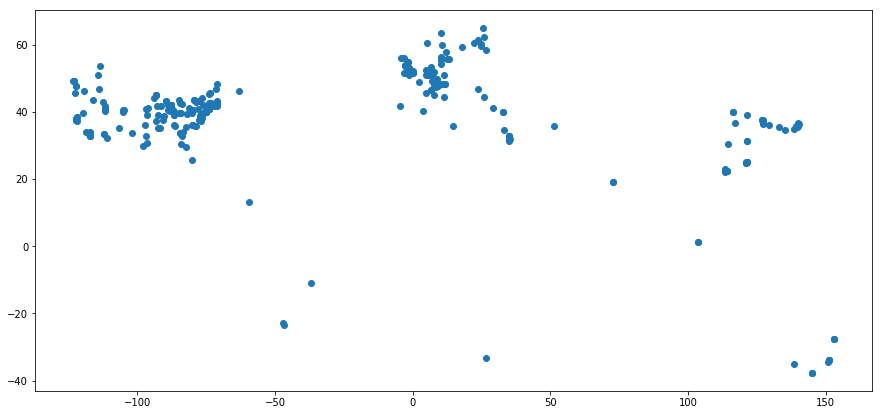

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.scatter(location_uni['Lon'],  location_uni['Lat'])

Fix error from wikipedia:

In [81]:
location_uni.loc[location_uni.University == 'McGill University', 'Lat'] = 45.5051283
location_uni.loc[location_uni.University == 'McGill University', 'Lon'] = -73.5820428

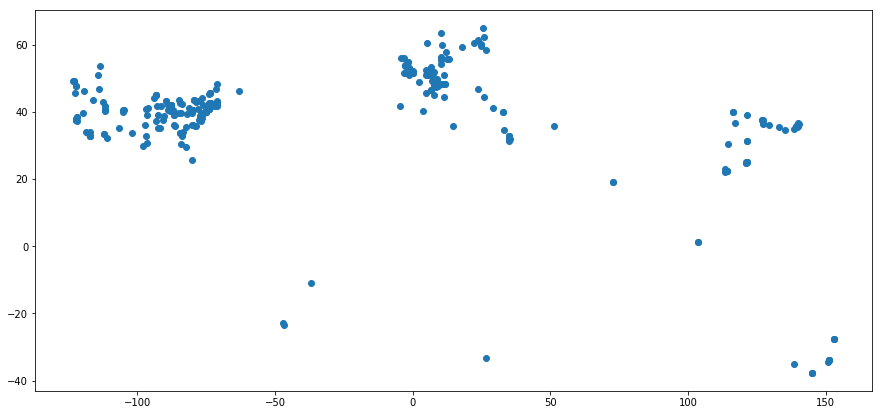

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.scatter(location_uni['Lon'],  location_uni['Lat'])

However, we still have 132 unfound locations!!

## Using an alternative method with geopy to get even more location matches:  

Using geopy every input will return some location, to avoid getting bad results we only check the location for Institutions, using the previously defined regex.

In [83]:
n_found_institutions = [i for i in  n_found if reg.search(match_institutions, i.lower())]

In [84]:
len(n_found_institutions)

59

hence we will try to find the location for 100 more places.

Geopy has the dissadvantage that we can only make 1 request per second, and it can't be used heavily. 
When re-run to often the api will reject the requests!

In [85]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="application_for_project_")

d= []
not_found = []
for n in n_found_institutions:
    location = geolocator.geocode(n)
    if location:
        d.append({'Lat': location.latitude, 'Lon': location.longitude, 'University': n})
    else:
        not_found.append(n)

In [86]:
additional_locations = pd.DataFrame(d)

In [87]:
additional_locations.head()

,Lat,Lon,University
0,51.025090,3.713542,Ghent University
1,30.284151,-97.731956,University of Texas at Austin
2,40.005709,-83.028663,"Ohio State University, Columbus"
3,57.015903,9.975328,"Aalborg University, Denmark"
4,1.338892,103.840717,"Ministry of Education, Singapore"


Now we can also associate a country to these universities, again using the country code:

A small issue we have is that countries in the special administrative zone of china will be mapped to china instead of their original location (Universities in HongKong will be mapped to china instead of Hong Kong).

In [89]:
countries = []
for i, row in additional_locations.iterrows():
    pos = str(row['Lat']) + ', ' + str(row['Lon'])
    country = geolocator.reverse(pos, timeout = 10)
    countries.append(country)

In [90]:
country_code_mapping = {}
_ = [country_code_mapping.update({c['alpha_two_code'].lower() : c['country']}) for c in parsed_json]

In [91]:
additional_locations['Country'] = pd.Series(
    [c.raw['address']['country_code'] for c in countries]).map(country_code_mapping)

In [92]:
additional_locations.head()

,Lat,Lon,University,Country
0,51.025090,3.713542,Ghent University,Belgium
1,30.284151,-97.731956,University of Texas at Austin,United States
2,40.005709,-83.028663,"Ohio State University, Columbus",United States
3,57.015903,9.975328,"Aalborg University, Denmark",Denmark
4,1.338892,103.840717,"Ministry of Education, Singapore",Singapore


the complete mapping is given by:

In [93]:
location_universities = pd.concat([additional_locations, location_uni], sort=False)

We can now again unify a bit by checking if we have the same locations:

In [94]:
rename_uni = {}
for i, row in location_universities.iterrows():
    for j, row_2 in location_universities.iterrows():
        if i < j and ',' not in row_2.University and row_2.University != row.University:
            if (row_2['Lon'] == row['Lon']) & (row_2['Lat'] == row['Lat']):
                number_used_row2 = emails[emails.name == row_2.University].shape[0]
                number_used_row = emails[emails.name == row.University].shape[0]
                if number_used_row > number_used_row2:
                    rename_uni[row_2.University] =  row.University
                else:
                    rename_uni[row.University] =  row_2.University

In [95]:
rename_uni

{'Clark University': 'Hiatt Center for Urban Education, Clark University',
 'Department of Psychology, Durham University': 'Durham University',
 'Ruhr-Universität Bochum': 'Ruhr-University Bochum',
 'School of Education, University of Nottingham': 'University of Nottingham',
 'The University of Wisconsin-Madison': 'University of Wisconsin - Madison',
 'University of California Berkeley': 'University of California, Berkeley',
 'University of California at Davis': 'University of California, Davis'}

We apply this renaming:

In [96]:
location_universities.loc[location_universities.University.isin(rename_uni.keys()), 'University'] = location_universities[location_universities.University.isin(rename_uni.keys())].University.map(rename_uni)

In [97]:
emails.loc[emails.name.isin(rename_uni.keys()),'name'] = emails.name.map(rename_uni)

In [98]:
universities = pd.merge(emails, location_universities, left_on='name', right_on='University', how='left')

In [99]:
universities.head()

,file,name,domain,email,author_order,country,Lat,Lon,University,Country
0,import2018_371,University of Colorado at Boulder,colorado.edu,rebecca.swanson@colorado.edu,0,United States,40.006667,-105.267222,University of Colorado at Boulder,United States
1,import2018_371,University of Colorado at Boulder,colorado.edu,leighanna.hinojosa@colorado.edu,1,United States,40.006667,-105.267222,University of Colorado at Boulder,United States
2,import2018_371,University of Colorado at Boulder,colorado.edu,joseph.polman@colorado.edu,2,United States,40.006667,-105.267222,University of Colorado at Boulder,United States
3,import2018_417,Indiana University at Bloomington,indiana.edu,huang220@indiana.edu,0,United States,39.167222,-86.521389,Indiana University at Bloomington,United States
4,import2018_417,Indiana University at Bloomington,gmail.com,agomoll90@gmail.com,1,United States,39.167222,-86.521389,Indiana University at Bloomington,United States


As mail extensions are a better indication, we use them as default and use the country found using the second method only we could not associate one using the first method:

In [100]:
universities[(universities.country != universities.Country) & (
    universities.country.isna()) & (universities.Country.notna())].head()

,file,name,domain,email,author_order,country,Lat,Lon,University,Country
53,import2015short_218,Utsunomiya University,kubota-lab.net,kubota@kubota-lab.net,4,NaN,36.549167,139.913889,Utsunomiya University,Japan
54,import2015short_218,Ibaraki University,suzuki-lab.net,hideyuki@suzuki-lab.net,5,NaN,36.401111,140.443056,Ibaraki University,Japan
92,import2018_211,University of Nottingham,gmail.com,nurjanah.mjaafar@gmail.com,0,NaN,52.938889,-1.196944,University of Nottingham,United Kingdom
93,import2018_211,University of Nottingham,gmail.com,nurjanah.mjaafar@gmail.com,0,NaN,52.938889,-1.196944,University of Nottingham,United Kingdom
174,import2016short_167,"Hiatt Center for Urban Education, Clark Univer...",gmail.com,kateb369@gmail.com,18,NaN,42.251111,-71.823056,"Hiatt Center for Urban Education, Clark Univer...",United States


To make sure that country names are uniform we first run a mapping from country to University:

In [101]:
universities[(universities.country != universities.Country) & (
    universities.country.notna()) & (universities.Country.notna())].head()

,file,name,domain,email,author_order,country,Lat,Lon,University,Country
537,import2017_59,Hallym University,hallym.ac.kr,heis@hallym.ac.kr,2,"Korea, Republic of",37.460000,126.950000,Hallym University,South Korea
563,import2015full_126,National Chengchi University,nccu.edu.tw,hyhong@nccu.edu.tw,0,Taiwan,24.986992,121.575222,National Chengchi University,China
597,import2018_202,Hanyang University,gmail.com,koreaspy21@gmail.com,0,"Korea, Republic of",37.556389,127.044444,Hanyang University,South Korea
598,import2018_202,Hanyang University,gmail.com,jinju.a.lee@gmail.com,1,"Korea, Republic of",37.556389,127.044444,Hanyang University,South Korea
599,import2018_202,Hanyang University,hanyang.ac.kr,kimdsik@hanyang.ac.kr,2,"Korea, Republic of",37.556389,127.044444,Hanyang University,South Korea


In [102]:
uni_uni = {}
for i, row in universities[universities.University.notna() & universities.country.notna()].iterrows():
    uni_uni[row.University] = row.country

In [103]:
universities.loc[universities.University.isin(uni_uni.keys()), 'country'] = universities.University.map(uni_uni)

In [104]:
universities.loc[(universities.country != universities.Country) & (
    universities.country.isna()) & (universities.Country.notna()), 'country'] = universities.Country

In [105]:
del universities['University'], universities['Country']

In [106]:
universities.to_pickle('../data/Universities.pkl')
universities.to_csv('../data/Universities.csv')

# Now with this data we can do some stuff:
- Papers with authors of different origin
- use predominant nation to remake above plot - maybe papers in the us have more coauthors -> need to find some way to normalize data
- look at cross institution & cross country
- maybe even look at cross continent collaboration